In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [3]:
# Loading data
data = pd.read_csv('INFY_2000_2008.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 16 columns):
Unnamed: 0                2496 non-null int64
Symbol                    2496 non-null object
Series                    2496 non-null object
Date                      2496 non-null object
Prev Close                2496 non-null float64
Open Price                2496 non-null float64
High Price                2496 non-null float64
Low Price                 2496 non-null float64
Last Price                2496 non-null float64
Close Price               2496 non-null float64
Average Price             2496 non-null float64
Total Traded Quantity     2496 non-null int64
Turnover                  2496 non-null float64
No. of Trades             2496 non-null object
Deliverable Qty           2496 non-null object
% Dly Qt to Traded Qty    2496 non-null object
dtypes: float64(8), int64(2), object(6)
memory usage: 312.1+ KB


In [65]:
# Selecting only Date and Average Price columns
data = data[['Date', 'Average Price']]

In [66]:
# Scaling the values in the range of 0 to 1
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_price = scaler.fit_transform(data.loc[:, 'Average Price'].values.reshape(-1, 1))

In [67]:
# Splitting dataset in the ratio of 75:25 for training and test
train_size = int(data.shape[0] * 0.75)
train, test = scaled_price[0:train_size, :], scaled_price[train_size:data.shape[0], :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (1872, 624)


In [68]:
def create_dataset(scaled_price, window_size=1):
    data_X, data_Y = [], []
    for i in range(len(scaled_price) - window_size - 1):
        a = scaled_price[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(scaled_price[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [77]:
# Create test and training sets for one-step-ahead regression.
window_size = 3
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(1868, 3)
New training data shape:
(1868, 1, 3)


The LSTM architecture here consists of:  

* One input layer.  
* One LSTM layer of 4 blocks.  
* One Dense layer to produce a single output.  
* MSE as loss function.  

In [84]:
# Designing the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape = (1, window_size)))
model.add(Dense(1))

# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")

# Training the model
model.fit(train_X, train_Y, epochs=3, batch_size=1)

Epoch 1/3
1868/1868 [==============================] - 11s 6ms/step - loss: 0.0121
Epoch 2/3
1868/1868 [==============================] - 8s 4ms/step - loss: 7.4263e-04
Epoch 3/3
1868/1868 [==============================] - 8s 4ms/step - loss: 5.9208e-04


In [85]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = np.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 394.74 RMSE
Test data score: 313.33 RMSE


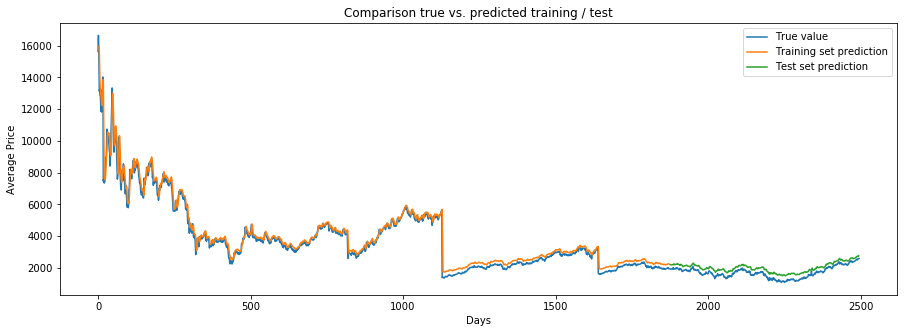

In [125]:
# Start with training predictions.
train_predict_plot = np.empty_like(scaled_price)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(scaled_price)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(scaled_price) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(scaled_price), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Average Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()